# Тетрадка содержит код для получения сабмита

In [1]:
%load_ext autoreload
import os
import re
import json
import pandas as pd
from datetime import datetime

from IPython.display import display

import matplotlib.pyplot as plt

from rbk.utils.global_vars import EMBEDDINGS_PATH, ROOT_ABSPATH, RAW_DATA_PATH, PREPARED_DATA_PATH, MODELS_PATH
from rbk.utils import helpers, prepare_data

# Загружаем данные

In [2]:
df_test = pd.read_parquet(os.path.join(ROOT_ABSPATH, PREPARED_DATA_PATH, 'test.parquet'))
df_train = pd.read_parquet(os.path.join(ROOT_ABSPATH, PREPARED_DATA_PATH, 'train.parquet'))
sample_submission = pd.read_csv(os.path.join(ROOT_ABSPATH, RAW_DATA_PATH, 'sample_solution.csv'))

full_embs = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'full_embs.parquet'))
titles_embs = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'titles_emb.parquet'))
tags_embs = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'tags_embs.parquet'))
authors_embs = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'authors_embs.parquet'))
first_part_embs = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'first_part_embs.parquet'))
last_part_embs = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'last_part_embs.parquet'))
topn_similar = pd.read_parquet(os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH, 'topn_similar.parquet'))

for emb_df in [full_embs, tags_embs, authors_embs, first_part_embs, last_part_embs, topn_similar]:
    df_test = df_test.join(emb_df)
    df_train = df_train.join(emb_df)

# Загружаем модели

In [3]:
model_views = helpers.load_pickle(os.path.join(ROOT_ABSPATH, MODELS_PATH, 'model_views.pickle'))
with open(os.path.join(ROOT_ABSPATH, MODELS_PATH, 'model_views_train_cols.json'), 'r', encoding='utf-8') as f:
              model_views_cols = json.load(f)

model_frp = helpers.load_pickle(os.path.join(ROOT_ABSPATH, MODELS_PATH, 'model_full_reads_percent.pickle'))
with open(os.path.join(ROOT_ABSPATH, MODELS_PATH, 'model_full_reads_percent_train_cols.json'), 'r', encoding='utf-8') as f:
              model_frp_cols = json.load(f)

model_depth = helpers.load_pickle(os.path.join(ROOT_ABSPATH, MODELS_PATH, 'model_depth.pickle'))
with open(os.path.join(ROOT_ABSPATH, MODELS_PATH, 'model_depth_train_cols.json'), 'r', encoding='utf-8') as f:
              model_depth_cols = json.load(f)

In [4]:
models = {'views': model_views, 'depth': model_depth, 'full_reads_percent': model_frp}
train_cols = {'views': model_views_cols, 'depth': model_depth_cols, 'full_reads_percent': model_frp_cols}

# Делаем прогноз для тестовых данных

In [5]:
predictions = pd.DataFrame(index=df_test.index)

In [6]:
for target_col in ['views', 'full_reads_percent', 'depth']:
       _, test = prepare_data.prepare_for_radar(df_test,
                                          train_cols[target_col],
                                          drop_duplicates=False,
                                          duplicates_subset=None)

       predicted = pd.Series(index=test.index, data=models[target_col].predict(test))
       predicted = predicted[df_test.index]
       predictions[target_col] = predicted

In [7]:
predictions = predictions.loc[sample_submission['document_id'], :].reset_index()
predictions = predictions[sample_submission.columns]

In [8]:
assert (predictions['document_id'] != sample_submission['document_id']).sum() == 0,\
    'Индексы сабмита и эталона не совпадают'
assert (predictions.columns != sample_submission.columns).sum() == 0,\
    'Колонки сабмита и эталона не совпадают'

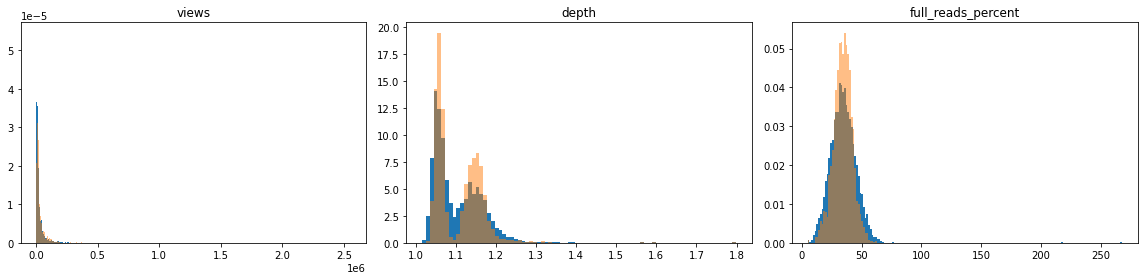

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
for i, col in enumerate(['views', 'depth', 'full_reads_percent']):
    bins = axs[i].hist(df_train[col], bins='auto', label='train', density=True)
    axs[i].hist(predictions[col], bins=bins[1], label='test', density=True, alpha=.5)
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

In [10]:
now = str(datetime.now())
now = now.split('.')[0]
now = re.sub(r'[^0-9]', '', now)
print(now)
submit_name = f'submit_{now}.csv'
predictions.to_csv(os.path.join(ROOT_ABSPATH, 'data', 'submits', submit_name), index=False)

20220719030915
